## Battle of Neighborhoods - Indian restaurant in New York

#### Introduction & Business Problem:

Business Problem:
In this project we will try to find an optimal location for opening a Indian restaurant in New York. This report will be targeted towards people who are interested in opening a new Indian restaurant in New York.

Since there are lots of Indian restaurants in New York, we will try to detect locations that are not already crowded with Indian restaurants or the ones where the ratings for the existing restaurants are low. We are also particularly interested in areas with minimum or no Indian restaurants in vicinity

We will use data science methodoly and techniques to arrive at an optimal location for opening the restaurant. This will ensure ROI of the investment by reducing risk of high competition and increasing the footfall (inturn the revenue)

#### Background:

The City of New York is famous for its array of international cuisines influenced by the city's immigrant history . The Indian population in New York City is over 650,000. Indians, the second largest Asian group in the city, comprised 20.5 percent of the Asian population. By borough, 65 percent of Indian New Yorkers lived in Queens, 12 percent in Manhattan, 12 percent in Brooklyn, 6.5 percent in the Bronx, and 5 percent in Staten Island. Neighborhoods with large Indian populations included South Ozone Park, Richmond Hill, Jackson Heights, Jamaica, Bellerose, Queens Village, Glen Oaks-Floral Park-New Hyde Park, Briarwood - Jamaica Hill, Elmhurst, and Flushing in Queens

Indians in New York City had higher median household and median family incomes than the general population. Indian median household income of USD 62,775 was higher than the citywide figure of USD 50,331. Median family income for Indians of USD 62,911 was above the citywide median family income of USD 55,434. Indian per capita income of USD 29,540 was close to the citywide figure of USD 30,717.

Given this background it is really an interesting proposition to open an Indian restaurant in New York, as it would make business sense and value

#### Data for the project
Based on our Business problem, the following factors will influence the decision making:
1. All existing Indian restaurants in the neighborhood
2. Ratings of the current Indian restaurants in various neighborhoods
3. NYC Indian population concentration across boroughs

Following data sources will be needed to extract/generate the above required information:
1. Demographics of NYC Data source: https://en.wikipedia.org/wiki/Demographics_of_New_York_City. Web scraping techniques will be used to get NYC’s population demographics from Wikipedia
2. Ratings and Number of existing Indian restaurants, their type and location in every neighborhood will be obtained using Foursquare API and https://cocl.us/new_york_dataset

The initial inference about of the market could be understood by web scraping the demographics data

#### Web scraping New York demographics

Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium
import os
import folium # map rendering library
# Matplotlib and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline

print('Libraries imported')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.3.1-py_0        conda-forge
    folium:          

Loading all jurisdiction wise demographics into the array

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Accessing Foursquare API to populate NYC details

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'EQVT52XUODAI4CULNCV1SLBWATUEP14L0WIIV2PD4A1VEXZK'
    CLIENT_SECRET ='BGZ4TBL31E2PQKDCVHE0KREHZSUB2W01IAYY0EOHE5SGMR1C' 
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'EQVT52XUODAI4CULNCV1SLBWATUEP14L0WIIV2PD4A1VEXZK'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='BGZ4TBL31E2PQKDCVHE0KREHZSUB2W01IAYY0EOHE5SGMR1C'# Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Getting New york data from the cocl.us dataset

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
new_york_data.shape

(306, 4)

## Methodology

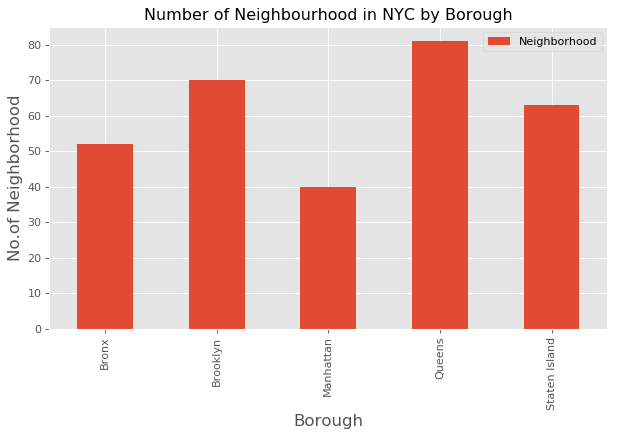

In [8]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

In [9]:
# prepare neighborhood list that contains indian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:1
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:1
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [10]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Norwood,57363fd4498eb703a5b5ea35,Aman Restaurant
2,Bronx,Williamsbridge,570c3a3fcd10eecd0d0434cd,Agra Grill
3,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
4,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine


In [11]:
indian_rest_ny.shape

(150, 4)

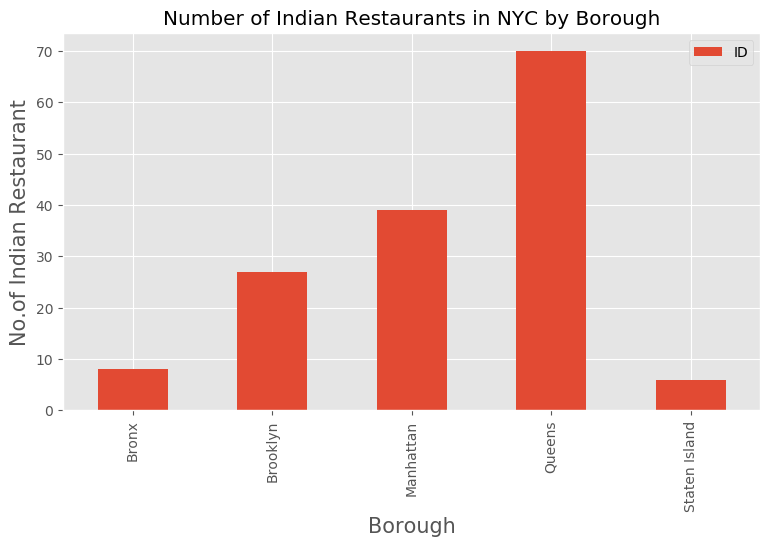

In [12]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Queens Borough has the highest number of Indian restaurants

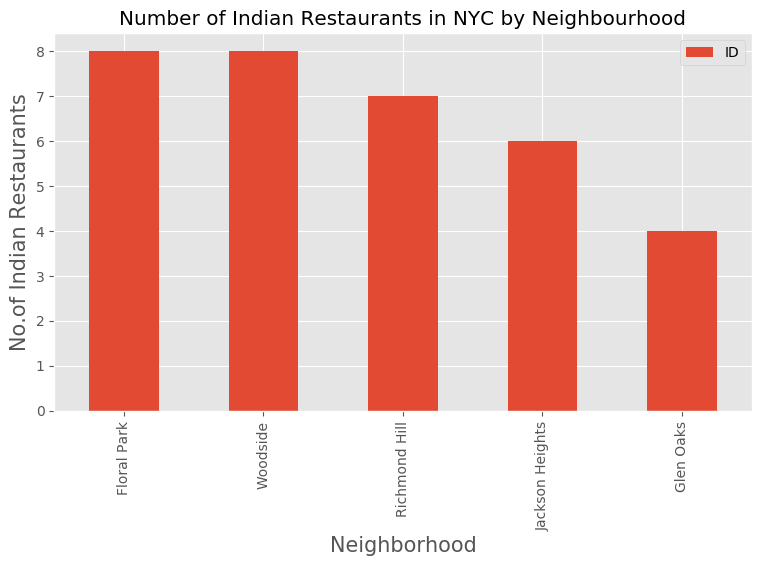

In [13]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Floral Park Neighborhood in Queens has the highest numver of Indian restaurants

In [74]:
## Getting the Likes, Rating and Tips data for each of the Indian restaurants

In [14]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.6    10
( 1 / 150 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 57363fd4498eb703a5b5ea35
( 2 / 150 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 570c3a3fcd10eecd0d0434cd
( 3 / 150 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.2     2
( 4 / 150 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 5 / 150 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.0     3
( 6 / 150 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c19463

In [15]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Norwood,0,0,0,0.0,0
2,Bronx,Williamsbridge,0,0,0,0.0,0
3,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2
4,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9


In [16]:
indian_rest_stats_ny.shape

(150, 7)

In [17]:
indian_rest_ny.shape

(150, 4)

In [18]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.shape

(150, 7)

In [19]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Norwood,0,0,0,0.0,0
2,Bronx,Williamsbridge,0,0,0,0.0,0
3,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2
4,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9


In [20]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
Borough         150 non-null object
Neighborhood    150 non-null object
ID              150 non-null object
Name            150 non-null object
Likes           150 non-null object
Rating          150 non-null float64
Tips            150 non-null object
dtypes: float64(1), object(6)
memory usage: 8.3+ KB


In [21]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [22]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [23]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
Borough         150 non-null object
Neighborhood    150 non-null object
ID              150 non-null object
Name            150 non-null object
Likes           150 non-null float64
Rating          150 non-null float64
Tips            150 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.3+ KB


## Grouping Neighborhood based on Average ratings received by the restaurants in the Neighborhood

In [41]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [42]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
70,Tribeca,9.00
76,West Village,8.85
45,Murray Hill,8.80
25,Fort Greene,8.70
11,Chelsea,8.70
54,Prospect Lefferts Gardens,8.60
48,North Side,8.50
63,South Side,8.50
2,Bay Ridge,8.40
62,Roosevelt Island,8.40


### Average rating of restaurants by Borough

In [43]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,5.748148
2,Manhattan,4.387179
0,Bronx,4.112500
3,Queens,0.000000
4,Staten Island,0.000000


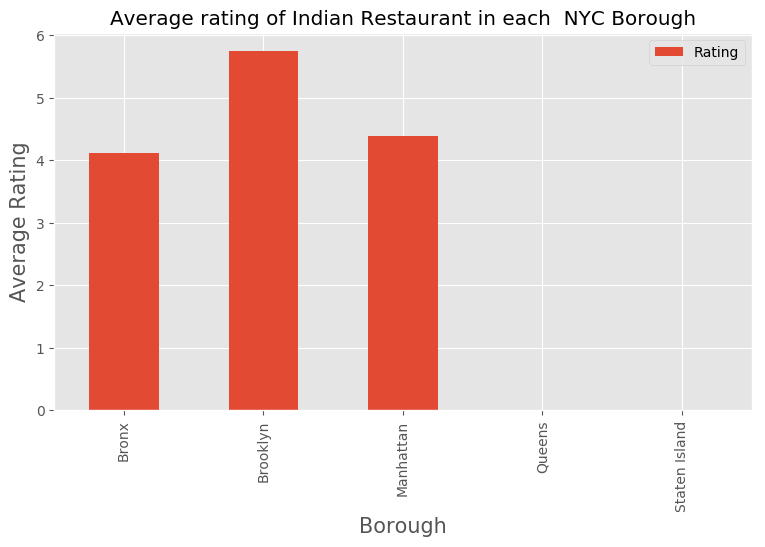

In [44]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Low the average ratings in a area, higher the possibility of gaining footfall if we are offering good food - since it could be either the restaurant is a new one or the quality is bad. In either case, it would be a good entry point

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating'] <5.0]

In [46]:
ny_neighborhood_stats 

,Neighborhood,Average Rating
0,Astoria,0.000
1,Astoria Heights,0.000
3,Bayside,0.000
4,Bellaire,0.000
5,Blissville,0.000
6,Briarwood,0.000
8,Broadway Junction,0.000
9,Carnegie Hill,0.000
12,City Line,0.000
13,Civic Center,0.000


In [47]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
26,Manhattan,Manhattan Valley,40.797307,-73.964286,3.925
37,Queens,Rego Park,40.728974,-73.857827,0.000
27,Brooklyn,Midwood,40.625596,-73.957595,0.000
28,Manhattan,Morningside Heights,40.808000,-73.963896,0.000
29,Staten Island,New Brighton,40.640615,-74.087017,0.000
30,Staten Island,New Dorp,40.572572,-74.116479,0.000
31,Bronx,Norwood,40.877224,-73.879391,0.000
32,Queens,Ozone Park,40.680708,-73.843203,0.000
33,Staten Island,Park Hill,40.609190,-74.080157,0.000
34,Queens,Queensboro Hill,40.744572,-73.825809,0.000


In [48]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [49]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [50]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [51]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

#### Findings

Murray Hill, Tribeca, Midtown in Manhattan are some of the best neighborhoods for Indian cuisine currently. Hence opening another restaurant is not advisable since the competition will be hectic
Bronx and Queens has the lowest rated Indian Resturants in NYC and they have 6.5% and 65.0% of the Indian population in NYC

#### Recommendation

Hence Queens would be the best choice to start a restaurant given that

1. it is the most populous (Indian population) urban area in New York City (NYC)
2. most of the restaurants are new or have a very ppor ratings in the locality
3. it has the highest Asian ethnic minority population in NYC